# Projet SDATA

## Exercice 1

In [16]:
import datetime

import numpy as np
import pandas

dataset_train = pandas.read_csv("dataset/spotify_dataset_train.csv")
dataset_test = pandas.read_csv("dataset/spotify_dataset_test.csv")

GENRE_MAP = ['blues', 'chanson', 'classical', 'country', 'dance', 'disco', 'edm', 'electro', 'folk', 'hip hop', 'jazz',
             'latin', 'metal', 'pop', 'punk', 'r&b', 'rap', 'reggae', 'rock', 'salsa', 'soul', 'techno']

for i, date in enumerate(dataset_train['release_date']):
    # Detect the date format and replace it with a utc timestamp for the train dataset
    if len(date.split('-')) == 3:
        dataset_train.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y-%m-%d").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    elif len(date.split('-')) == 2:
        dataset_train.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y-%m").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    elif len(date.split('-')) == 1:
        dataset_train.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    else:
        print(date)

    # Transform the genre string by the index equivalent
    dataset_train.loc[i, 'genre'] = GENRE_MAP.index(dataset_train.loc[i, 'genre'])

for i, date in enumerate(dataset_test['release_date']):
    # Detect the date format and replace it with a utc timestamp for the test dataset
    if len(date.split('-')) == 3:
        dataset_test.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y-%m-%d").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    elif len(date.split('-')) == 2:
        dataset_test.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y-%m").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    elif len(date.split('-')) == 1:
        dataset_test.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    else:
        print(date)

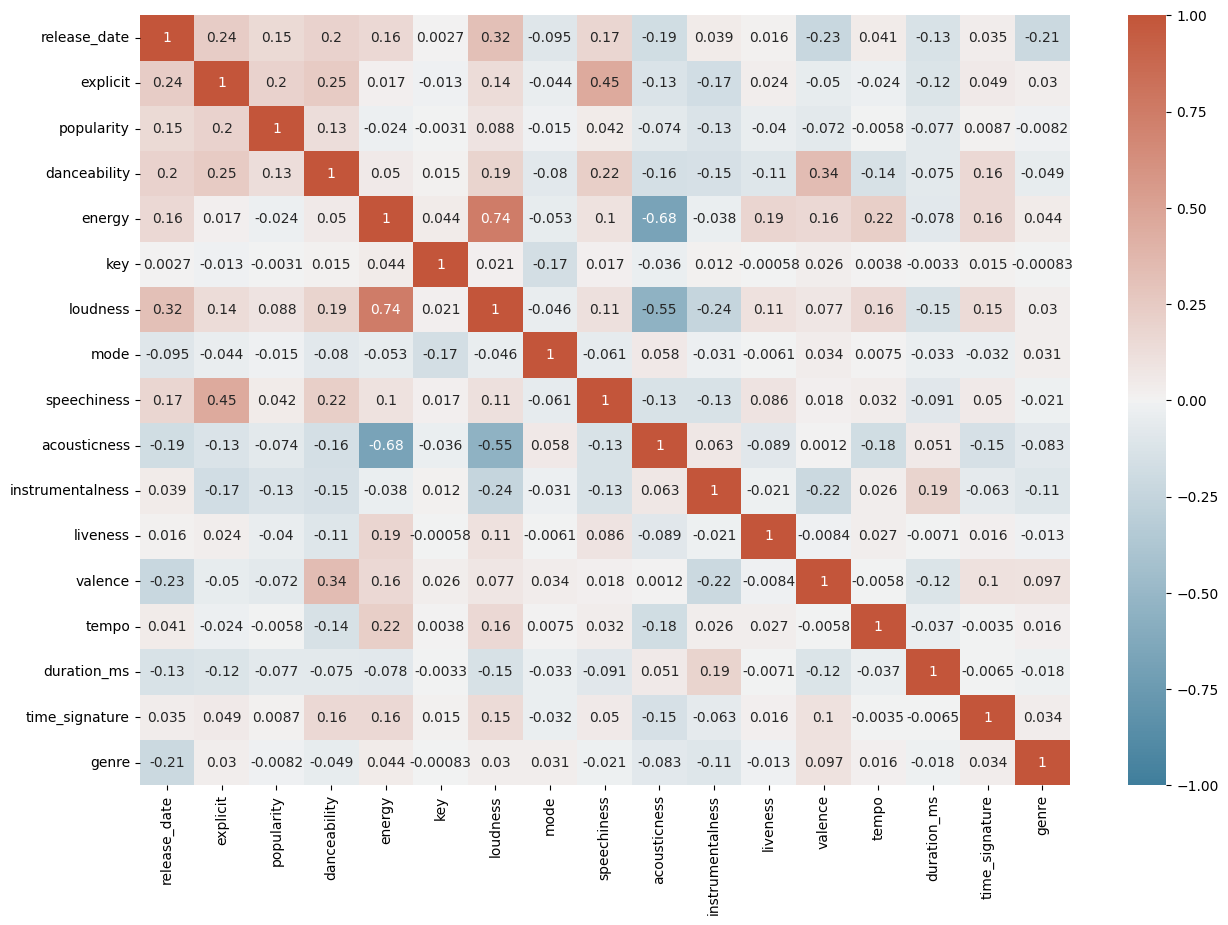

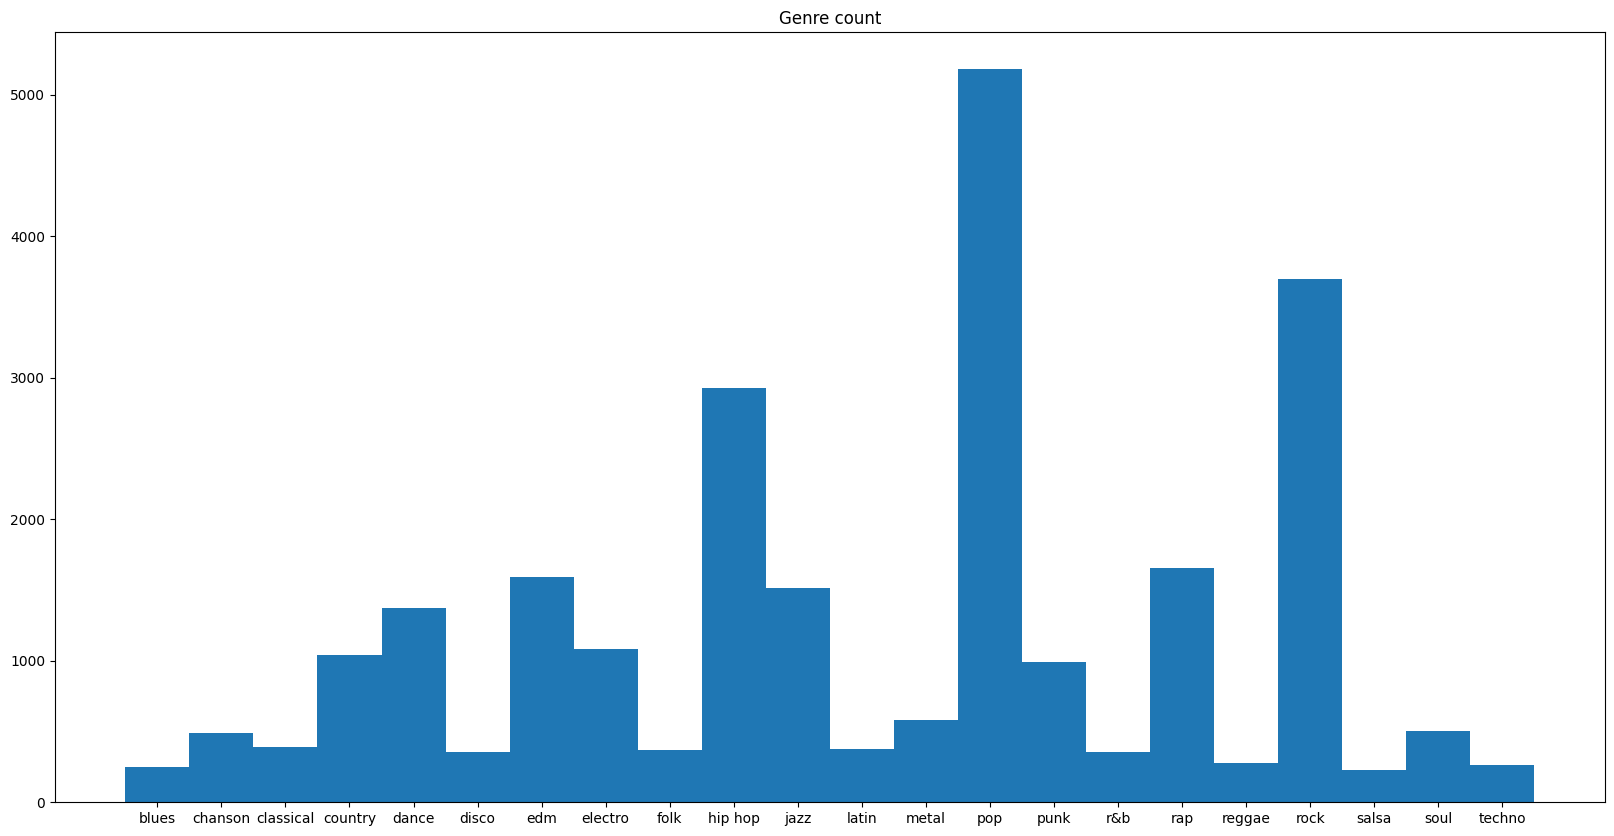

In [20]:
from matplotlib import pyplot as plt
import seaborn

# Correlation
corr = dataset_train.corr()
plt.figure(figsize=(15,10))
seaborn.heatmap(corr,
                cmap=seaborn.diverging_palette(230, 20, as_cmap=True),
                vmin=-1.0, vmax=1.0,
                square=False, annot=True)


# Genre count
plt.figure(figsize=(20,10))
genre_counts = [np.count_nonzero(dataset_train['genre'] == x) for x in range(len(GENRE_MAP))]
plt.bar(GENRE_MAP, genre_counts, width=1, align='center')
plt.title('Genre count')

plt.show()

In [37]:
# Keep only the interesting features to compare
interesting_features = np.array(["explicit", "popularity", "danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "valence", "tempo", "duration_ms"])
genres_compared = np.zeros(shape=(interesting_features.size, len(GENRE_MAP)))

# Fill the array column by column with the mean of each feature for each genre
for genre in range(genres_compared.shape[1]):
    # Returns an array containing the means for every feature
    genre_means = np.mean(dataset_train.iloc[np.where(dataset_train['genre'] == genre)], axis=0)
    for feature in range(genres_compared.shape[0]):
        genres_compared[feature][genre] = genre_means[interesting_features[feature]]

# Display the genre for the min and max value for each interesting feature
print(f"{'Feature':<20} {'Min':<15} {'Value':<15} {'Max':<15} {'Value':<15}")
for feature in range(genres_compared.shape[0]):
    # Find the index of the max and the min to get the genre associated
    min_genre = list(genres_compared[feature]).index(np.min(genres_compared[feature]))
    max_genre = list(genres_compared[feature]).index(np.max(genres_compared[feature]))

    print(f"{interesting_features[feature]:<20} ", end="")
    print(f"{GENRE_MAP[min_genre]:<15} ", end="")
    print(f"{round(genres_compared[feature][min_genre], 3):<15} ", end="")
    print(f"{GENRE_MAP[max_genre]:<15} ", end="")
    print(f"{round(genres_compared[feature][max_genre], 3):<15}")

Feature              Min             Value           Max             Value          
explicit             blues           0.0             hip hop         0.747          
popularity           salsa           8.978           r&b             41.849         
danceability         classical       0.308           reggae          0.763          
energy               classical       0.125           techno          0.866          
loudness             classical       -23.369         edm             -4.955         
speechiness          country         0.043           hip hop         0.23           
acousticness         techno          0.027           classical       0.925          
instrumentalness     country         0.01            classical       0.747          
valence              classical       0.194           salsa           0.859          
tempo                classical       102.124         techno          136.212        
duration_ms          punk            153819.613      techno      